In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from sklearn.ensemble import VotingClassifier

# Intro and Description

We will analyse a dataset of medical records of patients having heart failure released by Ahmad and colleagues in July 2017

In [2]:
heart_failure_data = pd.read_csv("heart_failure_clinical_records_dataset.csv")

In [3]:
heart_failure_data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


The dataset comprises of 13 columns. The definition of each column is below

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient deceased during the follow-up period (boolean)

More info found here - http://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records

# EDA

First we investigate the distrbution of data to understand our data, view outliers, check if the data is a true representation of the population and check with industry experts if the data makes sense / within the correct range

First let's investigate our categorical variables. We can see that the data isn't distributed evenly, this may be an accurate representation of the true population of heart failure patients. This will be a question to be discussed with an industry expert

In [4]:
categorical_vars = ["anaemia","diabetes","high_blood_pressure","sex","smoking"]

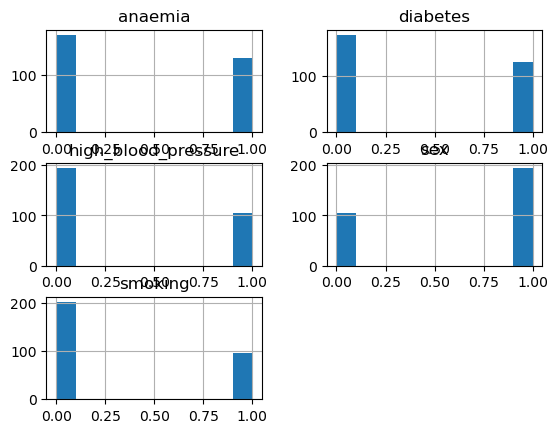

In [5]:
heart_failure_data[categorical_vars].hist()
plt.show()

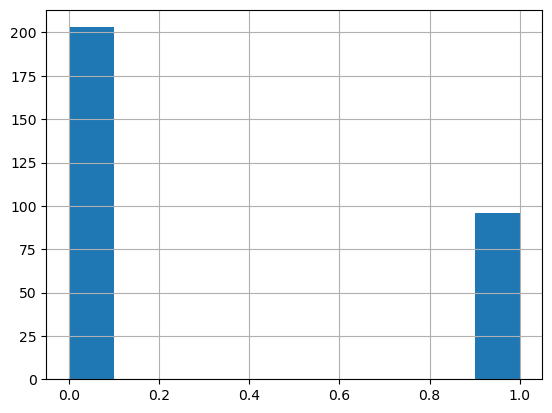

In [6]:
heart_failure_data["DEATH_EVENT"].hist()
plt.show()

Below we can see some skewed distributions in our continous data set. Again this will be a question to be discussed with an industry expert

In [7]:
continuous_cols = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]\

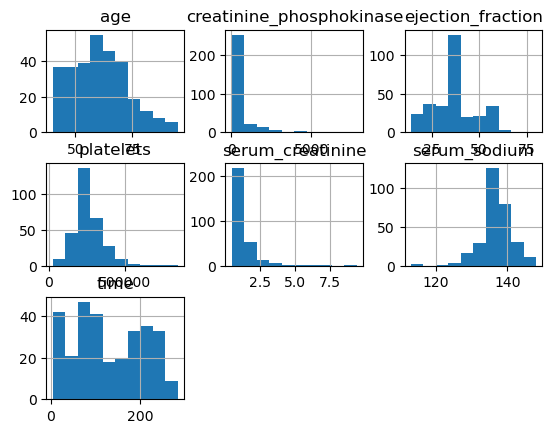

In [8]:
heart_failure_data[continuous_cols].hist()
# plt.subplots_adjust(left=None, bottom=1, right=1, top=10, wspace=1, hspace=None)
plt.show()

Using a box and whisker plot on the continuous data we can see outliers exist. The exclusion or inclusion of these variables will need to be discussed with an industry expert

In [9]:
continuous_cols
list(filter(lambda x: x != "creatinine_phosphokinase" and x != "platelets" and "serum_creatinine", continuous_cols))

['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']

In [10]:
cnt_cols_similar_range_1 = ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']


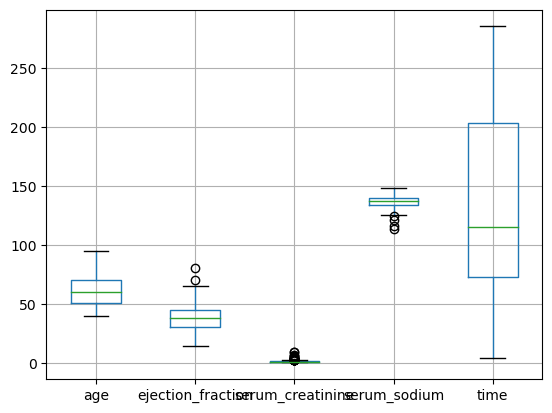

In [11]:
heart_failure_data.boxplot(column=cnt_cols_similar_range_1 )
plt.show()

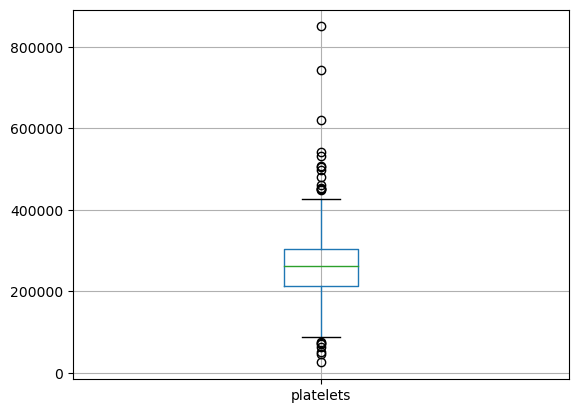

In [12]:
heart_failure_data.boxplot(column="platelets" )
plt.show()

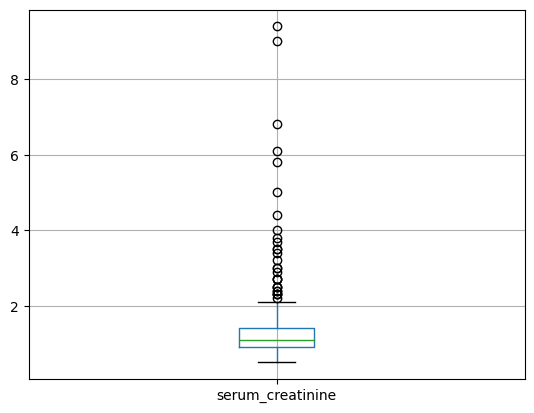

In [13]:
heart_failure_data.boxplot(column="serum_creatinine" )
plt.show()

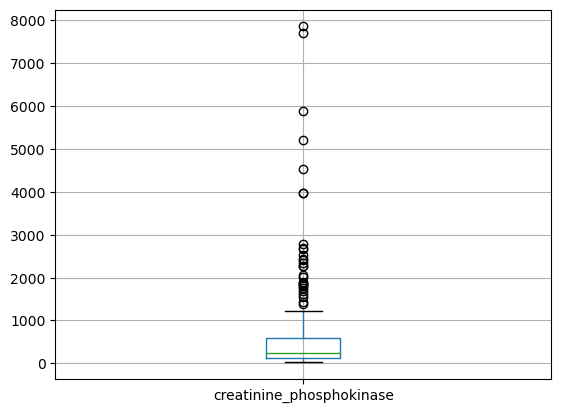

In [14]:
heart_failure_data.boxplot(column="creatinine_phosphokinase" )
plt.show()

## Linear Relationships

Let's investigate if DEATH_EVENT is linearly correlated to another column

In [15]:
corr_matrix = heart_failure_data.corr()

In [16]:
corr_matrix["DEATH_EVENT"].sort_values()

time                       -0.526964
ejection_fraction          -0.268603
serum_sodium               -0.195204
platelets                  -0.049139
smoking                    -0.012623
sex                        -0.004316
diabetes                   -0.001943
creatinine_phosphokinase    0.062728
anaemia                     0.066270
high_blood_pressure         0.079351
age                         0.253729
serum_creatinine            0.294278
DEATH_EVENT                 1.000000
Name: DEATH_EVENT, dtype: float64

At first glance we can see that death rate has strong correlations between age, ejection_fraction, serum_sodium, serum_creatinine, time

Let's perform a further investigation and capture the associated p values. This will allow us to identify what columns will be statistically significant in predicting a death event. To do so we will run two different test.<br>
We will use the Point Binserialiser to measure the relationship between continous columns and our categorical target column, DEATH_EVENT <br>
We will use the ChiSQ test to check if our categorical columns are closely related to our target categorical column, DEATH_EVENT

### Point Biserial Correlation

We will use the point biserial correlation  to measure the relationship between each continuous col and the binary variable DEATH_EVENT

In [17]:
def corr_between_cont_cols_and_target_cat_var(continuous_cols,target_cat_var):
    for col in continuous_cols:
        pbs = pointbiserialr(heart_failure_data[col], heart_failure_data[target_cat_var])
        print("col: {:<30} correlation: {:<25} pvalue {:<10} ".format(col, pbs.correlation, pbs.pvalue))

In [18]:
corr_between_cont_cols_and_target_cat_var(continuous_cols, "DEATH_EVENT")

col: age                            correlation: 0.2537285430880036        pvalue 8.916762946531661e-06 
col: creatinine_phosphokinase       correlation: 0.06272816025237474       pvalue 0.27961124573610285 
col: ejection_fraction              correlation: -0.2686033123940619       pvalue 2.4528974182084857e-06 
col: platelets                      correlation: -0.049138867980374284     pvalue 0.39719415404131725 
col: serum_creatinine               correlation: 0.29427756098414914       pvalue 2.1901978548975553e-07 
col: serum_sodium                   correlation: -0.19520359641640117      pvalue 0.0006889112363762405 
col: time                           correlation: -0.526963779277577        pvalue 9.122223384924721e-23 


Both platelets and creatinine_phosphokinase have a p value over 0.05 so we can assume they are not statistically relevant in predicting a death event.

We can see that the rest of the columns age, ejection_fraction, serum_sodium, serum_creatinine, time all have a p value under 0.05 and are statistically relevant in predicting a death event. Thus our continous feature columns: will be

<ul>
    <li>age</li>
    <li>ejection_fraction</li>
    <li>serum_sodium</li>
    <li>serum_creatinine</li>
    <li>time</li>
</ul>

### Chi Squared Test

We use the Chi Squared to check if categorical columns are associated. We will investigate each categorical columns relationship with a DEATH_EVENT

In [19]:
def corr_between_cat_cols_and_target_cat_var(categorical_vars,target_cat_var):
    for col in categorical_vars:
        chi2, pvalue, dof, ex = chi2_contingency(pd.crosstab(heart_failure_data[col],heart_failure_data[target_cat_var]))
        print("col: {:<30} chi2: {:<25} pvalue {:<10} ".format(col, chi2,pvalue))

In [20]:
corr_between_cat_cols_and_target_cat_var(categorical_vars, "DEATH_EVENT")

col: anaemia                        chi2: 1.042175485287005         pvalue 0.3073160508415107 
col: diabetes                       chi2: 0.008458101537285573      pvalue 0.9267235137291102 
col: high_blood_pressure            chi2: 1.5434607612967581        pvalue 0.21410341199416902 
col: sex                            chi2: 0.003037108721613983      pvalue 0.9560508538247334 
col: smoking                        chi2: 0.007331473567119502      pvalue 0.9317652998235507 


We can see that all the columns have a p value over 0.05 and thus we can assume that they are not statistically significant in predicting a DEATH_EVENT

### Conclusion

From our analysis above we can conclude that the variables needed for our model will be as follows:
<ul>
    <li>age</li>
    <li>ejection_fraction</li>
    <li>serum_sodium</li>
    <li>serum_creatinine</li>
    <li>time</li>
</ul>

## Feature Engineering

In [21]:
feature_cols = ["age","ejection_fraction","serum_sodium","serum_creatinine","time"]

First let's check for null values

In [22]:
heart_failure_data.columns[heart_failure_data.isnull().any()]

Index([], dtype='object')

No nulls exist within the dataset

As we can see below, each column uses a different range. We will need to scale this

In [23]:
heart_failure_data[feature_cols].head()

,age,ejection_fraction,serum_sodium,serum_creatinine,time
0,75.0,20,130,1.9,4
1,55.0,38,136,1.1,6
2,65.0,20,129,1.3,7
3,50.0,20,137,1.9,7
4,65.0,20,116,2.7,8


## Model Creation

In [24]:
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [25]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

### Split datasets

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
heart_failure_data[feature_cols], heart_failure_data["DEATH_EVENT"], test_size=0.2, random_state=0)

In [27]:
# cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

# Models

Our aim is to use logistic regression, random forest and svm in an ensemble. In order to get the 'best' possible models for our ensemble we will perform hyperparameter on each model


In [28]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model_params = {
    'svm': {
        'model_pipeline': Pipeline([('scaler', StandardScaler()), ('SVM', SVC())]),
        'params' : {
            'SVM__C': [1,10,20,40],
            'SVM__gamma':[0.1,0.01],
            'SVM__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model_pipeline': Pipeline([('scaler', StandardScaler()), ('random_forest', RandomForestClassifier())]),
        'params' : {
            'random_forest__n_estimators': [1,5,10,20,40]
        }
    },
    'logistic_regression' : {
        'model_pipeline': Pipeline([('scaler', StandardScaler()), ('logistic_reg', LogisticRegression(solver='liblinear',multi_class='auto'))]),
        'params': {
            'logistic_reg__C': [1,5,10]
        }
    }
}


In [29]:
def get_model_scores(model_params):
    scores = []
    for model_name, mp in model_params.items():
        clf =  GridSearchCV(mp['model_pipeline'], param_grid=mp['params'], cv=10, return_train_score=False)
        clf.fit(X_train, y_train)
        scores.append({
            'model': model_name,
            'best_score': clf.best_score_,
            'best_params': clf.best_params_
        })
    return scores
    

In [30]:
# View the hyper parameters within the pipeline
# Pipeline([('scaler', StandardScaler()), ('random_forest', RandomForestClassifier())]).get_params().keys()

In [31]:
model_scores = get_model_scores(model_params)

In [32]:
pd.set_option('max_colwidth', 400)

In [33]:
df = pd.DataFrame(model_scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.853623,"{'SVM__C': 10, 'SVM__gamma': 0.01, 'SVM__kernel': 'rbf'}"
1,random_forest,0.870290,{'random_forest__n_estimators': 10}
2,logistic_regression,0.836957,{'logistic_reg__C': 1}


We can see the accuracy of each model below

In [34]:
svm_clf = Pipeline([('scaler', StandardScaler()), ('SVM', svm.SVC(C=10,gamma=0.01,kernel="rbf",probability=True))])
svm_clf.fit(X_train, y_train)
svm_clf.score(X_test, y_test)

0.7833333333333333

In [60]:
random_forest = Pipeline([ ('random_forest', RandomForestClassifier(n_estimators=20))])
random_forest.fit(X_train, y_train)
random_forest.score(X_test, y_test)

0.8166666666666667

In [61]:
logistic_regression = Pipeline([('scaler', StandardScaler()), ('random_forest', LogisticRegression(C=1))])
logistic_regression.fit(X_train, y_train)
logistic_regression.score(X_test, y_test)

0.8

We will now group it in a voting classifier

In [62]:
voting_clf = VotingClassifier(
    estimators=[("svc", svm_clf),("rf",random_forest),("lr", logistic_regression)],
    voting="soft"
)
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.8166666666666667

## Additional Work

Look for non-linear relationships

Talk to industry experts about the distributions and erroneous data